[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/examples/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)

In [ ]:
from open_atmos_jupyter_utils import show_plot

TOC:
- run a basic constant-coefficient advection-diffusion simulation with Trixi.jl
- run analogous simulation with PyMPDATA
- compare output

## common settings

In [7]:
SETUP = {
    "nx": 32,
    "ny": 16,
    "Cx": 0.5,
    "Cy": 0.25,
    "dt": 0.025,
    "tmax": 1.0
}

import json
with open('setup1.json', 'w', encoding='UTF-8') as f:
    json.dump(SETUP, f)

## Trixi.jl

In [ ]:
%%writefile trixi.jl
import Pkg
Pkg.add(["JSON", "Trixi", "OrdinaryDiffEq"])
using JSON
using Trixi
using OrdinaryDiffEq


setup = JSON.parsefile("setup.json")
advection_velocity = (setup["Cx"], setup["Cy"])
equations = LinearScalarAdvectionEquation2D(advection_velocity)

solver = DGSEM(polydeg = 3)

cells_per_dimension = (setup["nx"], setup["ny"])
coordinates_min = (-1.0, -1.0)
coordinates_max = ( 1.0,  1.0)

mesh = StructuredMesh(cells_per_dimension, coordinates_min, coordinates_max)
semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition_convergence_test, solver)

tspan = (0.0, setup["tmax"])
ode = semidiscretize(semi, tspan);

summary_callback = SummaryCallback()
save_solution = SaveSolutionCallback(interval=100)

stepsize_callback = StepsizeCallback(cfl = 1.6)

callbacks = CallbackSet(summary_callback, save_solution, stepsize_callback)

time_int_tol = 1e-6
sol = solve(ode, CarpenterKennedy2N54();
            abstol = time_int_tol,
            reltol = time_int_tol,
            dt = setup["dt"],
            ode_default_options()..., callback = callbacks);

summary_callback()

In [ ]:
%%bash
julia trixi.jl 2>&1

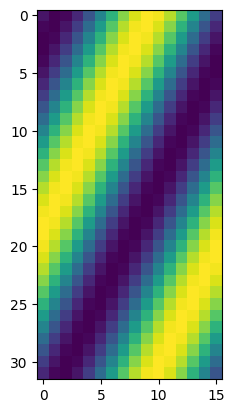

In [18]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

with h5py.File('out/solution_000026.h5', 'r') as f:
    # average every 16 points to reduce the number of points
    temp = np.array([np.mean(x) for x in f['variables_1'][:].reshape(-1, 16)])
    plt.imshow(temp[:].reshape(SETUP['ny'], SETUP['nx']).transpose())
    plt.show()

## PyMPDATA

In [1]:
import os
import numpy as np
import sympy as sp
from IPython.display import display
from ipywidgets import FloatProgress
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic

In [2]:
steps_per_iter = 1
opt = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, nonoscillatory=True)

In [3]:
x0 = -1.
y0 = -1.
boundary_conditions = (Periodic(), Periodic())

In [8]:
mu = 0.0
c = 1.
min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / SETUP['nx']
dy = (max_y - min_y) / SETUP['ny']
solution_symbolic = sp.sympify("sin(pi*(x+y))*exp(-mu*pi**2*t) + 1", rational=True)
solution = solution_symbolic.subs({"mu": mu})

In [9]:
def init_conditions(x, y):
    return solution_symbolic.subs({"t":0, "x": x, "y": y}).evalf()

In [10]:
z = np.array(
    [
        # [
            init_conditions(x, y) for x in np.linspace(min_x, max_x, SETUP['nx'])
        # ]
        for y in np.linspace(min_y, max_y, SETUP['ny'])
    ],
    dtype=float
).reshape((SETUP['nx'], SETUP['ny']))

In [11]:
advectee = ScalarField(data=z, halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [12]:
field_x = np.full((SETUP['nx']+1, SETUP['ny']), SETUP['Cx'], dtype=opt.dtype)
field_y = np.full((SETUP['nx'], SETUP['ny']+1), SETUP['Cy'], dtype=opt.dtype)
advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [13]:
stepper = Stepper(options=opt, n_dims=2)

In [14]:
# create a solver
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

NameError: name 'show_plot' is not defined

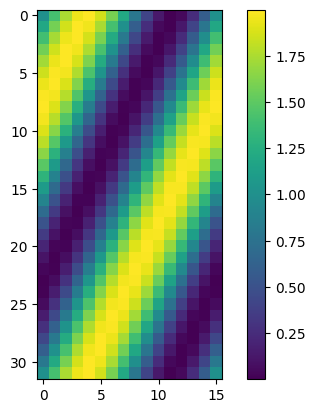

In [15]:
plt.imshow(solver.advectee.get().copy(), cmap='viridis')
plt.colorbar()
show_plot()

In [16]:
progbar = FloatProgress(value=0, min=0, max=1)
display(progbar)

states_history = [solver.advectee.get().copy()]
n_steps = 10
n_range = int(SETUP['tmax'] / SETUP['dt']) // n_steps
for i in range(n_range):
    solver.advance(n_steps=n_steps, mu_coeff=(mu, mu))
    states_history.append(solver.advectee.get().copy())
    progbar.value = (i + 1.) / n_range

FloatProgress(value=0.0, max=1.0)

In [26]:
trixi_result = temp[:].reshape(SETUP['ny'], SETUP['nx']).transpose()

# Calculate rmse between Trixi and PyMPDATA output
rmse = np.sqrt(np.mean((states_history[-1] - trixi_result) ** 2))
print(f"RMSE: {rmse}")

# Calculate min-max difference between Trixi and PyMPDATA output
min_max_diff = np.max(np.abs(states_history[-1] - trixi_result))
print(f"Min-max difference: {min_max_diff}")

RMSE: 0.5736000432480288
Min-max difference: 0.9386086838491452


In [32]:
with h5py.File('out/solution_000000.h5', 'r') as f:
    trixi_init = np.array([np.mean(x) for x in f['variables_1'][:].reshape(-1, 16)])
    trixi_init = trixi_init[:].reshape(SETUP['ny'], SETUP['nx']).transpose()

In [33]:
assert np.abs(np.sum(states_history[-1]) - np.sum(states_history[0])) < 1e-6
assert np.abs(np.sum(trixi_result) - np.sum(trixi_init)) < 1e-6

NameError: name 'show_plot' is not defined

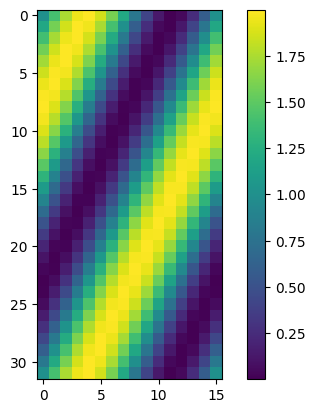

In [34]:
solution_symbolic_final = sp.sympify("sin(pi*(x-cx*t + y-cy*t)) + 1", rational=True)
def final_conditions(x, y):
    return solution_symbolic_final.subs({"cx": SETUP['Cx'], "cy": SETUP['Cy'], "t":SETUP['tmax'], "x": x, "y": y}).evalf()

z_final = np.array(
    [
        # [
            final_conditions(x, y) for x in np.linspace(min_x, max_x, SETUP['nx'])
        # ]
        for y in np.linspace(min_y, max_y, SETUP['ny'])
    ],
    dtype=float
).reshape((SETUP['nx'], SETUP['ny']))

plt.imshow(z, cmap='viridis')
plt.colorbar()
show_plot()

In [35]:
# Calculate rmse between analytical solution, Trixi and PyMPDATA output
rmse = np.sqrt(np.mean((states_history[-1] - z_final) ** 2))
print(f"PyMPDATA - RMSE: {rmse}")

rmse = np.sqrt(np.mean((trixi_result - z_final) ** 2))
print(f"Trixi - RMSE: {rmse}")

PyMPDATA - RMSE: 0.5819680013615011
Trixi - RMSE: 0.36475393214749774


In [36]:
# Calculate min-max difference between analytical solution, Trixi and PyMPDATA output
min_max_diff = np.max(np.abs(states_history[-1] - z_final))
print(f"PyMPDATA - Min-max difference: {min_max_diff}")

min_max_diff = np.max(np.abs(trixi_result - z_final))
print(f"Trixi - Min-max difference: {min_max_diff}")

PyMPDATA - Min-max difference: 1.149813434544938
Trixi - Min-max difference: 0.5395098189482272


In [ ]:
# save each frame as a png to animation2 folder
os.makedirs("animation2", exist_ok=True)
for i, state in enumerate(states_history):
    # flip the image vertically
    state = np.flipud(state)
    plt.imshow(state, cmap='viridis')
    plt.colorbar()
    plt.savefig(f"animation2/frame_{i:03d}.png")
    plt.close()

In [ ]:
def get_advection_diffusion_gif(states):
    fig, ax = plt.subplots()
    ax.set_xlim(0, SETUP['nx'])
    ax.set_ylim(0, SETUP['ny'])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Advection-Diffusion Equation")
    im = ax.imshow(states[0], cmap='viridis')
    def update(i):
        im.set_array(states[i])
        return im,
    anim = FuncAnimation(fig, update, frames=len(states), blit=True)
    
    anim.save("advection_diffusion.gif", writer='imagemagick', fps=10)

In [ ]:
get_advection_diffusion_gif(states_history)

Load VTK file

In [ ]:
from vtk.util.numpy_support import vtk_to_numpy
import vtk
import meshio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mesh = meshio.read("solution_000026.vtu")

In [ ]:
# mesh.point_data["scalar"]

In [ ]:
arr = np.array(mesh.point_data["scalar"])

In [ ]:
# [x.data for x in  mesh.cells]

In [ ]:
# mesh.cells[0].data.shape

In [ ]:
# for block in [x for x in mesh.cells]:
#     print(np.array(block.data).shape)

In [ ]:
arr = arr[::16]
plt.imshow(arr.reshape(16, 32, order="C").transpose())
plt.show()